# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [1]:
!pip install -q scikit-learn==1.1.3

In [2]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor, Pool, cv
import lightgbm as lgb
import warnings
warnings.filterwarnings("ignore")

In [3]:
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.1.3.


## Ведение

**Подготовка данных**

Загрузим, рассмотрим имеющиеся данные, удалим ненужные столбцы для обучения, а также поработаем с выбросами.

**Обучение моделей**

Разделим данные на выборки, также применим методики прямого кодирования и масштабирования. Обучим модели и посмотрим на их показатели: RMSE, время обучения, время предсказания.

**Анализ моделей**

Выберем лучшую с точки зрения всех показателей. Произведем предсказание на тестовой выборке.

## Подготовка данных

### Откроем данные и изучим их

In [4]:
try:
    data = pd.read_csv('C:/datasets/autos.csv')
except:
    data = pd.read_csv('/datasets/autos.csv')
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [7]:
print(data['Brand'].unique(), data['VehicleType'].unique(), data['Model'].unique(),sep='\n')

['volkswagen' 'audi' 'jeep' 'skoda' 'bmw' 'peugeot' 'ford' 'mazda'
 'nissan' 'renault' 'mercedes_benz' 'opel' 'seat' 'citroen' 'honda' 'fiat'
 'mini' 'smart' 'hyundai' 'sonstige_autos' 'alfa_romeo' 'subaru' 'volvo'
 'mitsubishi' 'kia' 'suzuki' 'lancia' 'toyota' 'chevrolet' 'dacia'
 'daihatsu' 'trabant' 'saab' 'chrysler' 'jaguar' 'daewoo' 'porsche'
 'rover' 'land_rover' 'lada']
[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 't

In [8]:
data.columns = data.columns.str.lower()
data = data.rename(columns = {'datecrawled':'date_crawled', 'vehicletype': 'vehicle_type', 'registrationyear': 'registration_year', 
                              'registrationmonth': 'registration_month', 'fueltype': 'fuel_type', 'datecreated': 'date_created', 
                              'numberofpictures': 'number_of_pictures', 'postalcode': 'postal_code', 'lastseen': 'last_seen'})
data.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

<div class="alert alert-block alert-info">
<b>Комментарий:</b> Преобразуем названия столбцов в удобный нам вид.
</div>

In [9]:
data.drop(['date_crawled', 'registration_month', 'date_created', 'number_of_pictures', 'postal_code', 'last_seen'], 
          inplace = True, axis=1)
data.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'fuel_type', 'brand', 'repaired'],
      dtype='object')

<div class="alert alert-block alert-info">
<b>Комментарий:</b> Удалим ненужные столбцы, которые не участвуют в обучении.
</div>

### Предобработка

In [10]:
data.isna().sum()/len(data)*100

price                 0.000000
vehicle_type         10.579368
registration_year     0.000000
gearbox               5.596709
power                 0.000000
model                 5.560588
kilometer             0.000000
fuel_type             9.282697
brand                 0.000000
repaired             20.079070
dtype: float64

<AxesSubplot:ylabel='kilometer'>

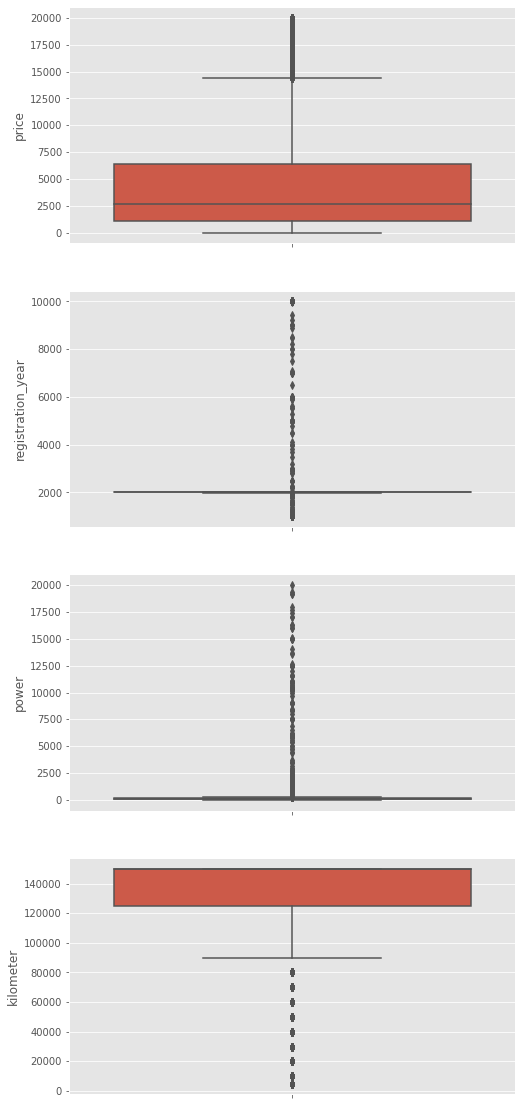

In [11]:
fig_1, (ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(8,20))
sns.boxplot(ax = ax1, y='price',data=data)
sns.boxplot(ax = ax2, y='registration_year',data=data)
sns.boxplot(ax = ax3, y='power',data=data)
sns.boxplot(ax = ax4, y='kilometer',data=data)

<div class="alert alert-block alert-info">
<b>Комментарий:</b> Kilometer выглядит нормально, а вот остальные данные не очень, registration_year и power имеют много аномальных значений, price имеет много нулей или очень низких цен. Сначала разберемся с годами.
</div>

In [12]:
print('Будет удалено данных:', 
      (len(data) - len(data.query('registration_year > 1980 & registration_year <= 2016')))/len(data)*100, '%')

Будет удалено данных: 5.240300364873902 %


In [13]:
print('Кол-во до удаления:', len(data))
data = data[(data['registration_year'] > 1980) & (data['registration_year'] <= 2016)]
print('Кол-во после удаления:', len(data))
data.reset_index(drop=True, inplace=True)

Кол-во до удаления: 354369
Кол-во после удаления: 335799


<div class="alert alert-block alert-info">
<b>Комментарий:</b> Данных было удалено не много.
</div>

<div class="alert alert-block alert-info">
<b>Комментарий:</b> Модель будет тяжело восстановить, этих данных также не много, удалим их, чтобы через группировку бренда и модели заполнить пропущенные категориальные значения самыми распространенными.
</div>

In [14]:
data = data.dropna(subset=['model']).reset_index(drop=True)
print('Кол-во данных:', len(data))

Кол-во данных: 319165


In [15]:
func = lambda x: x.mode().iloc[0]
data = data.fillna(data.groupby(['brand','model']).transform(func))

In [16]:
data.isna().sum()

price                0
vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
kilometer            0
fuel_type            0
brand                0
repaired             0
dtype: int64

<div class="alert alert-block alert-info">
<b>Комментарий:</b> От пропусков избавились перейдем к выбросам.
</div>

<div class="alert alert-block alert-info">
<b>Комментарий:</b> Начнем со столбца power. Будем группировать по брендам, моделям, типу кузова, и топливу, брать среднее и заполнять там, где очень маленькие значения, очень большие удалим, их весьма мало.
</div>

In [17]:
print('Кол-во до удаления:', len(data))
data = data.drop(data.query('power > 500').index).reset_index(drop=True)
print('Кол-во после удаления:', len(data))

Кол-во до удаления: 319165
Кол-во после удаления: 318798


In [18]:
data.loc[data.query('power < 50').index, 'power'] = data.groupby(['brand','model','vehicle_type','fuel_type'])['power'].transform('mean')[data.query('power < 50').index.values]

In [19]:
print('Кол-во до удаления:', len(data))
data = data.drop(data.query('power < 50').index).reset_index(drop=True)
print('Кол-во после удаления:', len(data))

Кол-во до удаления: 318798
Кол-во после удаления: 316113


<div class="alert alert-block alert-info">
<b>Комментарий:</b> Удалим остатки, которые по прежнему очень малы.
</div>

<div class="alert alert-block alert-info">
<b>Комментарий:</b> По такой же схеме как и со столбцом power, обработаем выбросы столбца price, правда нас интересует только нижняя граница
</div>

In [20]:
data.loc[data.query('price < 500').index, 'price'] = data.groupby(['brand','model','vehicle_type', 'kilometer', 'registration_year'])['price'].transform('mean')[data.query('price < 500').index.values]

In [21]:
print('Кол-во до удаления:', len(data))
data = data.drop(data.query('price < 500').index).reset_index(drop=True)
print('Кол-во после удаления:', len(data))

Кол-во до удаления: 316113
Кол-во после удаления: 310617


<AxesSubplot:ylabel='kilometer'>

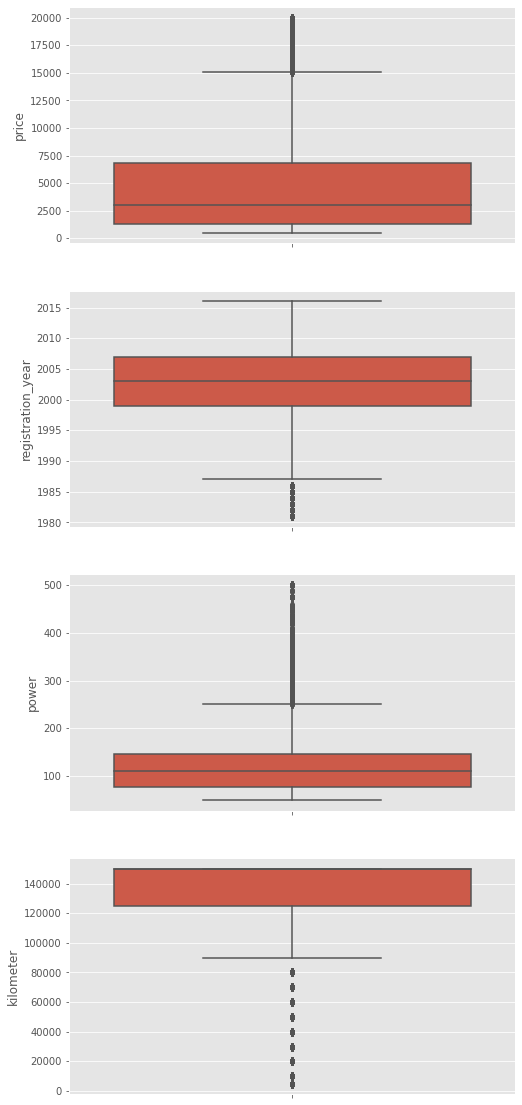

In [22]:
fig_1, (ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(8,20))
sns.boxplot(ax = ax1, y='price',data=data)
sns.boxplot(ax = ax2, y='registration_year',data=data)
sns.boxplot(ax = ax3, y='power',data=data)
sns.boxplot(ax = ax4, y='kilometer',data=data)

<div class="alert alert-block alert-info">
<b>Комментарий:</b> Ящики с усами выглядят приемлемо.
</div>

## Обучение моделей

### Подготовим данные к обучению

<div class="alert alert-block alert-info">
<b>Комментарий:</b> Масштабируем и закодируем признаки.
</div>

In [23]:
target = data['price']
features = data.drop(['price'], axis=1)
features_train, features_test, target_train, target_test, = train_test_split(features,target, 
                                                                             train_size=0.8, random_state=12345)
features_train.reset_index(drop=True, inplace=True)
target_train.reset_index(drop=True, inplace=True)
features_test.reset_index(drop=True, inplace=True)
target_test.reset_index(drop=True, inplace=True)
print('Общий размер:', features.shape, target.shape, 
      '\nРазмер тренировочной выборки:', features_train.shape, target_train.shape,
      '\nРазмер тестовой выборки:', features_test.shape, target_test.shape)

Общий размер: (310617, 9) (310617,) 
Размер тренировочной выборки: (248493, 9) (248493,) 
Размер тестовой выборки: (62124, 9) (62124,)


In [24]:
numeric_features = features_train.select_dtypes(exclude='object').columns.to_list()
categoric_features = features_train.select_dtypes(include='object').columns.to_list()
print('Категориальные данные:', categoric_features)
print('Количественные данные:', numeric_features)

Категориальные данные: ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']
Количественные данные: ['registration_year', 'power', 'kilometer']


<div class="alert alert-block alert-info">
<b>Комментарий:</b> OHE кодирование выполено после разбиения на выборки. Также  ходе проб и ошибок, было выявлено, что CatboostRegressor показывает результат лучше при предварительном кодировании, а LGBMRegressor наоборот лучше при встроенном кодировании. В соотсветсвии с этими данным и были подготовлены выборки. 
</div>

#### Выборка для LinearRegression

In [25]:
features_train_ohe = features_train.copy()
features_test_ohe = features_test.copy()

encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

encoder_ohe.fit(features_train_ohe[categoric_features])

scaler_ohe = StandardScaler()

# добавляем закодированные признаки, предварительно разбив на два датасета, поскольку если делать это с одним большим
# происходит coredumped
first_part = features_train_ohe.shape[0]//2
temp_first_part = features_train_ohe[:first_part]
temp_second_part = features_train_ohe[first_part:features_train_ohe.shape[0]]

temp_first_part[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(temp_first_part[categoric_features])
temp_second_part[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(temp_second_part[categoric_features])
features_train_ohe = pd.concat([temp_first_part,temp_second_part])

features_train_ohe = features_train_ohe.drop(categoric_features, axis=1)

scaler_ohe.fit(features_train_ohe[numeric_features])
features_train_ohe[numeric_features] = scaler_ohe.transform(features_train_ohe[numeric_features])

features_train_ohe.shape

(248493, 303)

In [26]:
features_test_ohe[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_test_ohe[categoric_features])

features_test_ohe = features_test_ohe.drop(categoric_features, axis=1)
features_test_ohe[numeric_features] = scaler_ohe.transform(features_test_ohe[numeric_features])
features_test_ohe.shape

(62124, 303)

In [27]:
print('Несовпадений в столбцах:',(features_train_ohe.columns != features_test_ohe.columns).sum())

Несовпадений в столбцах: 0


#### Выборка для CatBoostRegressor

In [28]:
features_train_ore = features_train.copy()
features_test_ore = features_test.copy()

encoder_ore = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1) 

encoder_ore.fit(features_train_ore[categoric_features])

scaler_ore = StandardScaler()

features_train_ore[categoric_features] = encoder_ore.transform(features_train_ore[categoric_features])

scaler_ore.fit(features_train_ore[numeric_features])
features_train_ore[numeric_features] = scaler_ore.transform(features_train_ore[numeric_features])

features_train_ore.shape

(248493, 9)

In [29]:
features_test_ore[categoric_features] = encoder_ore.transform(features_test_ore[categoric_features])

features_test_ore[numeric_features] = scaler_ore.transform(features_test_ore[numeric_features])
features_test_ore.shape

(62124, 9)

In [30]:
print('Несовпадений в столбцах:',(features_train_ore.columns != features_test_ore.columns).sum())

Несовпадений в столбцах: 0


#### Выборка для LGBMRegressor

In [31]:
features_train_lgb = features_train.copy()
features_train_lgb[categoric_features] = features_train[categoric_features].astype('category')

scaler_lgb = StandardScaler()

scaler_lgb.fit(features_train_lgb[numeric_features])
features_train_lgb[numeric_features] = scaler_lgb.transform(features_train_lgb[numeric_features])

print(features_train_lgb.shape)
features_train_lgb.dtypes

(248493, 9)


vehicle_type         category
registration_year     float64
gearbox              category
power                 float64
model                category
kilometer             float64
fuel_type            category
brand                category
repaired             category
dtype: object

In [32]:
features_test_lgb = features_test.copy()
features_test_lgb[categoric_features] = features_test[categoric_features].astype('category')

features_test_lgb[numeric_features] = scaler_lgb.transform(features_test_lgb[numeric_features])
features_test_lgb.shape

(62124, 9)

In [33]:
print('Несовпадений в столбцах:',(features_train_lgb.columns != features_test_lgb.columns).sum())

Несовпадений в столбцах: 0


### Обучим модели

In [34]:
model_linear_reg = LinearRegression()

In [35]:
%%time
model_linear_reg.fit(features_train_ohe,target_train);

CPU times: user 21.6 s, sys: 12 s, total: 33.7 s
Wall time: 33.7 s


LinearRegression()

In [36]:
%%time
linear_predict = model_linear_reg.predict(features_train_ohe)

CPU times: user 163 ms, sys: 37.7 ms, total: 200 ms
Wall time: 195 ms


In [37]:
print("LinearRegression RMSE:", mean_squared_error(target_train, linear_predict)**0.5)

LinearRegression RMSE: 2447.848487784839


In [38]:
%%time
CBR = CatBoostRegressor(random_state=12345, verbose = False, loss_function ='RMSE')
parameters_CBR = {'depth': [4,5,6,7],
                  'learning_rate': [0.03,0.1],
                  'iterations': [10, 20,30,40]}
grid_CBR = GridSearchCV(CBR, param_grid = parameters_CBR, 
                        cv=5, scoring = "neg_mean_squared_error", n_jobs=-1)

CPU times: user 417 µs, sys: 61 µs, total: 478 µs
Wall time: 165 µs


In [39]:
%%time
grid_CBR.fit(features_train_ore, target_train)
print("CatBoost GridCV RMSE:", np.sqrt(grid_CBR.best_score_*(-1)))
print("Параметры модели CatBoostRegressor:", grid_CBR.best_params_)

CatBoost GridCV RMSE: 1836.9354515151913
Параметры модели CatBoostRegressor: {'depth': 7, 'iterations': 40, 'learning_rate': 0.1}
CPU times: user 1min 56s, sys: 1.2 s, total: 1min 57s
Wall time: 3min 4s


In [40]:
%%time 
cat_predict = grid_CBR.best_estimator_.predict(features_train_ore)
print("CatBoost GridCV RMSE:", mean_squared_error(target_train, cat_predict)**0.5)

CatBoost GridCV RMSE: 1839.4009632225939
CPU times: user 40.8 ms, sys: 972 µs, total: 41.8 ms
Wall time: 39.9 ms


In [41]:
%%time
grid_CBR_random = RandomizedSearchCV(CBR, param_distributions = parameters_CBR, 
                                     cv=5, scoring = "neg_mean_squared_error", n_jobs=-1)

CPU times: user 20 µs, sys: 1e+03 ns, total: 21 µs
Wall time: 25 µs


In [42]:
%%time
grid_CBR_random.fit(features_train_ore, target_train)
print("CatBoost RandomCV RMSE:", np.sqrt(grid_CBR_random.best_score_*(-1)))
print("Параметры модели CatBoostRegressor:", grid_CBR_random.best_params_)

CatBoost RandomCV RMSE: 1979.0746576064475
Параметры модели CatBoostRegressor: {'learning_rate': 0.1, 'iterations': 30, 'depth': 6}
CPU times: user 35.1 s, sys: 373 ms, total: 35.5 s
Wall time: 54.8 s


In [43]:
%%time 
cat_predict_random = grid_CBR_random.best_estimator_.predict(features_train_ore)
print("CatBoost RandomCV RMSE:", mean_squared_error(target_train, cat_predict_random)**0.5)

CatBoost RandomCV RMSE: 1976.5830576981998
CPU times: user 25 ms, sys: 3.77 ms, total: 28.7 ms
Wall time: 26.7 ms


In [44]:
lgb_model = lgb.LGBMRegressor(metric = 'rmse',random_state=12345)

In [45]:
%%time
lgb_model.fit(features_train_lgb,target_train)

CPU times: user 5min 35s, sys: 5.23 s, total: 5min 40s
Wall time: 5min 43s


LGBMRegressor(metric='rmse', random_state=12345)

In [46]:
%%time
lgb_predict = lgb_model.predict(features_train_lgb)

CPU times: user 2.46 s, sys: 114 µs, total: 2.46 s
Wall time: 2.5 s


In [47]:
print("LGBMRegressor RMSE:", mean_squared_error(target_train, lgb_predict)**0.5)

LGBMRegressor RMSE: 1485.7935793540041


In [48]:
results = pd.DataFrame(data={'RMSE': [mean_squared_error(target_train, linear_predict)**0.5, 
                                      mean_squared_error(target_train, cat_predict)**0.5,
                                      mean_squared_error(target_train, cat_predict_random)**0.5,
                                      mean_squared_error(target_train, lgb_predict)**0.5], 
                             'time_learning' : ['32.5s', '1min 57s', '35.5s', '5min 40s'],
                             'time_predict': ['200ms','41.8ms', '28.7ms','2.46s']},
                       index = ['LinearRegression', 'CatBoostRegressor GridCV',
                                'CatBoostRegressor RandomCV' , 'LGBMRegressor'])
results

,RMSE,time_learning,time_predict
LinearRegression,2447.848488,32.5s,200ms
CatBoostRegressor GridCV,1839.400963,1min 57s,41.8ms
CatBoostRegressor RandomCV,1976.583058,35.5s,28.7ms
LGBMRegressor,1485.793579,5min 40s,2.46s


<div class="alert alert-block alert-info">
<b>Комментарий:</b> В лучше всех себя показывает LinearRegression. Она обучалась и быстрее при неизменных параметрах.
</div>

<div class="alert alert-block alert-info">
<b>Комментарий:</b> Теперь лучше всех себя показал CatBoostRegressor обученный случайным подбором параметров. Он чуточку хуже по времени, но весьма лучше по RMSE.
</div>

In [50]:
%%time
grid_CBR_random_predict = grid_CBR_random.predict(features_test_ore)

CPU times: user 8.99 ms, sys: 48 µs, total: 9.04 ms
Wall time: 7.62 ms


In [51]:
print("RMSE:", mean_squared_error(target_test, grid_CBR_random_predict)**0.5)

RMSE: 1989.8715085637534


## Вывод

LinearRegression имеет самую лучшую скорость, но самый плохой показатель RMSE. LGBMRegressor имеет самое длительное обучение, но лучший показатель RMSE. CatBoostRegressor был рассмотрен с двумя разными вариантами подбора параметров, random лучше по скорости, но хуже по метрике, grid наоборот. Таким образом разные модели могут использоваться при разных вариантах того, какой параметр является важнейшим.